In [2]:
import numpy as np
from scipy.stats import mannwhitneyu, ks_2samp
from statistics import *
import pandas as pd
import eztao
import matplotlib.pyplot as plt

In [5]:
# read in data

df = pd.read_csv('1ES_binned_lc.csv')
pred_df = pd.read_csv('1ES_pred_DHO_lc.csv')

lc, pred_lc = df['scaled lumin'].values, pred_df['lumin'].values

In [6]:
# Calculate the Cohen's effect size
d = cohens_d(lc, pred_lc)

# Calculate the Mann-Whitney U test and KS test
stat, p_value_mw = mannwhitneyu(lc, pred_lc)
stat, p_value_ks = ks_2samp(lc, pred_lc)

print(f"Cohen's d: {d}")
print(f"Mann-Whitney U Test p-value: {p_value_mw}")
print(f"KS Test p-value: {p_value_ks}")

Cohen's d: 0.0006909178292597341
Mann-Whitney U Test p-value: 0.9787170758991969
KS Test p-value: 0.999855974661082


Cohen's d: measure of effect size, indicates the standardized difference between two means. Very small value suggests that the mean difference between the actual and predicted RQA metrics is minimal

Mann-Whitney U Test p-value is much higher than the common alpha level of 0.05, indicating that there is no statistically significant difference between the distributions of the actual and predicted RQA metrics

KS Test p-value: high p-value suggests that the two distributions are not significantly different

RQA metrics from the actual light curve and the predicted one from the DHO model do not show significant differences. This implies that the DHO model may be capturing the dynamics of the AGN light curve to a degree that is statistically indistinguishable from the actual data, at least based on the RQA metrics used

In [3]:
df = pd.read_fwf('../data/1ES_optical-UV.dat', delim_whitespace=True)
df.columns = ['mjd', 'time', 'I', 'mag', 'error', 'instrument', 'band']
g = df[df['band'] == 'g']
v = df[df['band'] == 'V']
df

,mjd,time,I,mag,error,instrument,band
0,56736.573,-1347.457,,17.754,0.35,ASAS-SN,V
1,56740.591,-1343.516,l,18.250,0.00,ASAS-SN,V
2,56741.588,-1342.537,,16.624,0.15,ASAS-SN,V
3,56750.557,-1333.739,l,18.450,0.00,ASAS-SN,V
4,56755.571,-1328.820,,17.604,0.33,ASAS-SN,V
...,...,...,...,...,...,...,...
708,58622.552,502.591,,17.263,0.10,ATLAS,o
709,58622.562,502.601,,17.443,0.12,ATLAS,o
710,58626.553,506.516,,17.143,0.05,ATLAS,o
711,58626.558,506.521,,16.833,0.04,ATLAS,o


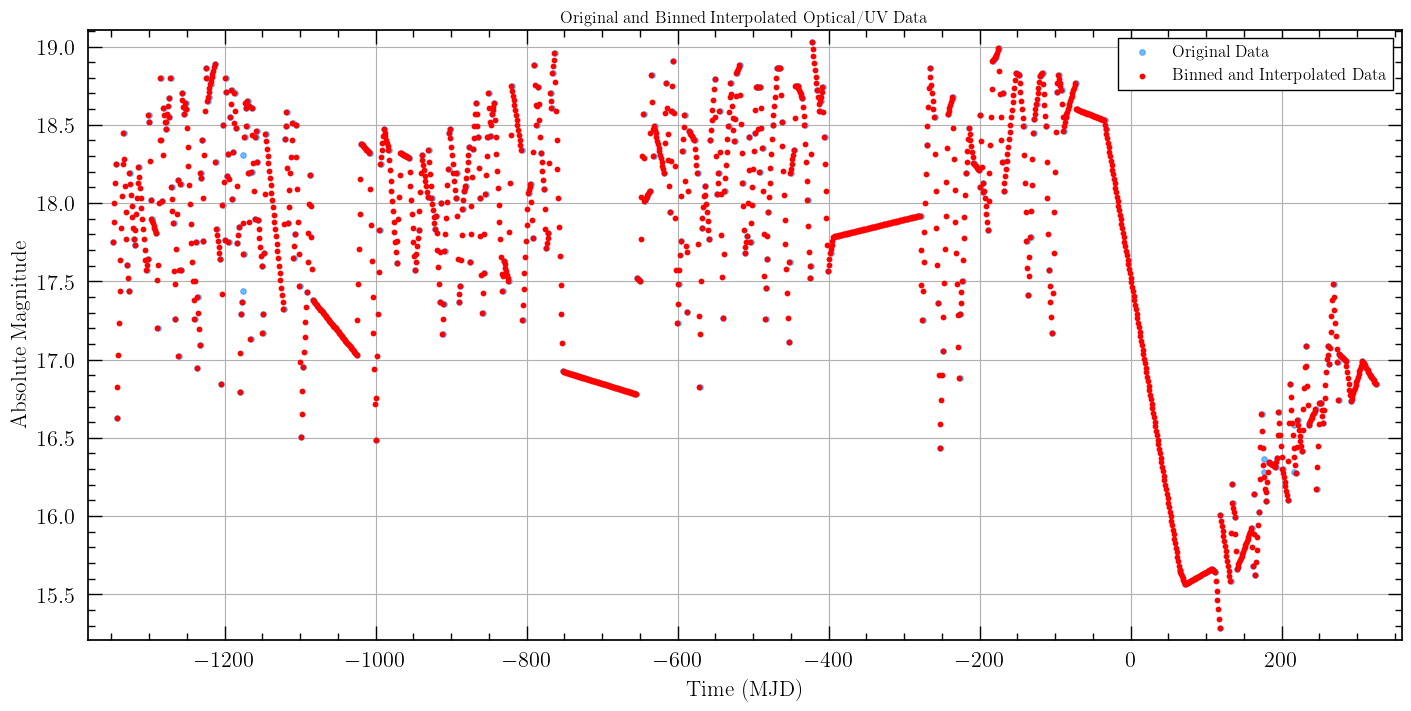

In [4]:
# Define the interpolation function using cubic spline interpolation
from scipy.interpolate import interp1d

data = v

time = data['time'].values #- data['mjd'].values[0]
luminosity = data['mag'].values

daily_time_grid = np.arange(np.floor(time.min()), np.ceil(time.max()) + 1, 1)
binned_data = pd.DataFrame(index=daily_time_grid[:-1])  # Exclude the last edge
binned_data['mag'] = np.nan

# Aggregate original data into bins by taking the mean for each day
# If multiple measurements fall into one bin, they are averaged
for i, day in enumerate(daily_time_grid[:-1]):
    # Find data points within this day
    daily_data = data[(time >= day) & (time < day + 1)]
    if not daily_data.empty:
        binned_data.loc[day, 'mag'] = daily_data['mag'].mean()


# Define the interpolation function using a linear spline ('slinear' in scipy's interp1d)
linear_spline = interp1d(binned_data.dropna().index, binned_data.dropna()['mag'],
                                           kind='slinear', fill_value='extrapolate')

# Interpolate the luminosity values using the linear spline function at the new time points
interpolated_lumin= linear_spline(daily_time_grid[:-1])

# Update the binned data with the linear spline interpolated values
binned_data['mag'] = interpolated_lumin

# Plot the original and interpolated data
plt.figure(figsize=(14, 7))
plt.scatter(time, data['mag'], color='dodgerblue', s=15, alpha=0.6, label='Original Data')
plt.scatter(binned_data.index, binned_data['mag'], color='red', s=10, label='Binned and Interpolated Data', zorder=5)
plt.xlabel('Time (MJD)')
plt.ylabel('Absolute Magnitude')
plt.title('Original and Binned Interpolated Optical/UV Data')
# plt.yscale('log')
plt.legend()
plt.grid(True)


ValueError: 'yerr' must not contain negative values

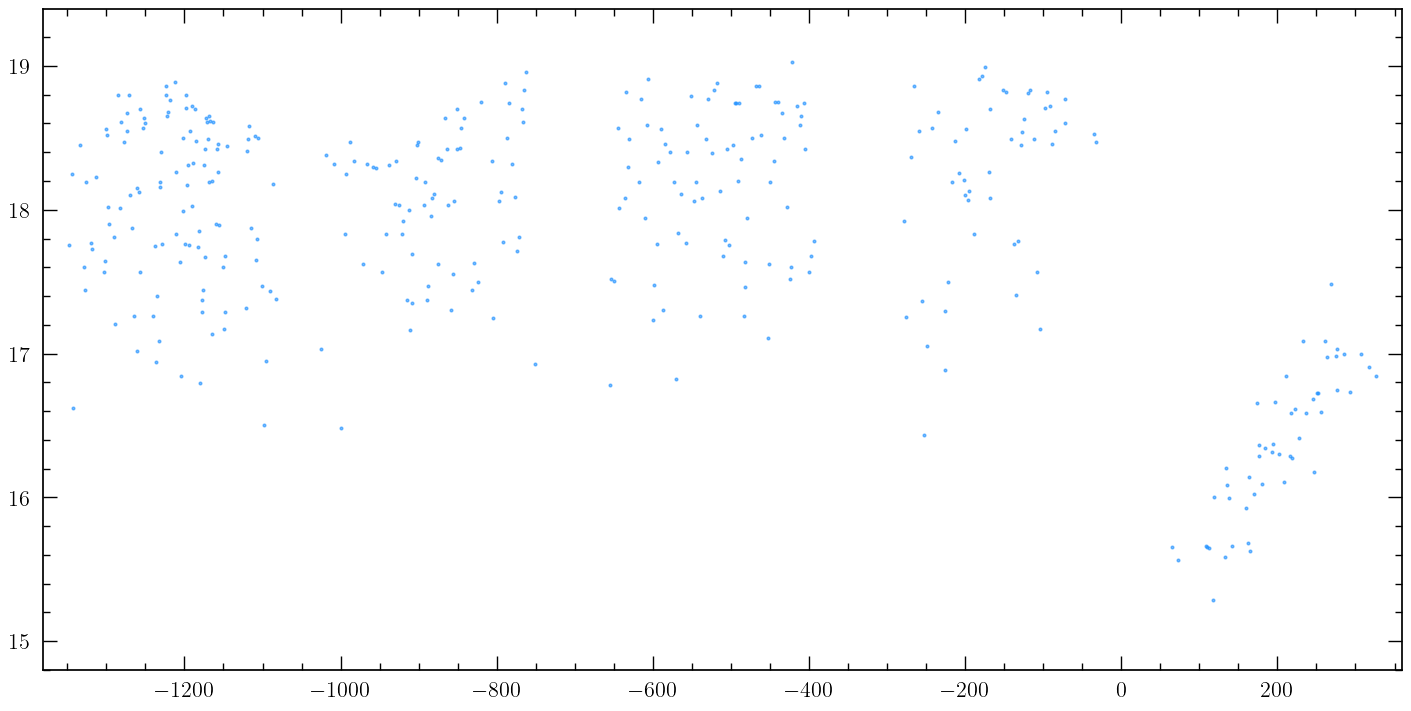

In [26]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d

data = v

time = data['time'].values
luminosity = data['mag'].values
errors = data['error'].values

daily_time_grid = np.arange(np.floor(time.min()), np.ceil(time.max()) + 1, 1)
binned_data = pd.DataFrame(index=daily_time_grid[:-1])  # Exclude the last edge
binned_data['mag'] = np.nan
binned_data['error'] = np.nan

# Aggregate original data into bins by taking the mean for each day
# If multiple measurements fall into one bin, they are averaged
# Errors are combined using the mean of the upper and lower errors
for i, day in enumerate(daily_time_grid[:-1]):
    # Find data points within this day
    daily_data = df[(df['time'] >= day) & (df['time'] < day + 1)]
    if not daily_data.empty:
        binned_data.loc[day, 'mag'] = daily_data['mag'].mean()
        # Propagate the errors using the mean of upper and lower errors
        binned_data.loc[day, 'error'] = daily_data['error'].mean()

# Define the interpolation function using a linear spline ('slinear' in scipy's interp1d)
linear_spline = interp1d(binned_data.dropna().index, binned_data.dropna()['mag'],
                         kind='slinear', fill_value='extrapolate')

# Interpolate the luminosity values using the linear spline function at the new time points
interpolated_lumin = linear_spline(daily_time_grid[:-1])

# Update the binned data with the linear spline interpolated values
binned_data['mag'] = interpolated_lumin

# Handling error for interpolated points
# Simple approach to interpolate errors linearly (might not be suitable for all cases)
error_spline = interp1d(binned_data.dropna().index, binned_data.dropna()['error'],
                        kind='linear', fill_value='extrapolate')
interpolated_error = error_spline(daily_time_grid[:-1])
binned_data['error'] = interpolated_error


# Plot the original and interpolated data
plt.figure(figsize=(14, 7))
plt.scatter(data['time'], data['mag'], color='dodgerblue', s=15, alpha=0.6, label='Original Data', marker='.')
plt.errorbar(binned_data.index, binned_data['mag'], yerr=binned_data['error'], color='k', alpha=0.5, marker="", linestyle="", zorder=6)
plt.scatter(binned_data.index, binned_data['mag'], color='red', s=10, label='Binned and Interpolated Data', zorder=6, marker='.')
plt.xlabel('Time (MJD)')
plt.ylabel('Absolute Magnitude')
plt.title('Original and Binned Interpolated Optical/UV Data')
# plt.yscale('log')
plt.legend()
plt.grid(True)

In [7]:
binned_data['time'] = binned_data.index
binned_data.to_csv('../data/1ES_rebinned_ASSN_V.csv', index=None)
# binned_data

In [30]:
v.to_csv('../data/1ES_ASSN_V_lc.csv', index=None)

Error: must supply twinxlabel if twinx supplied, not plotting twinx.


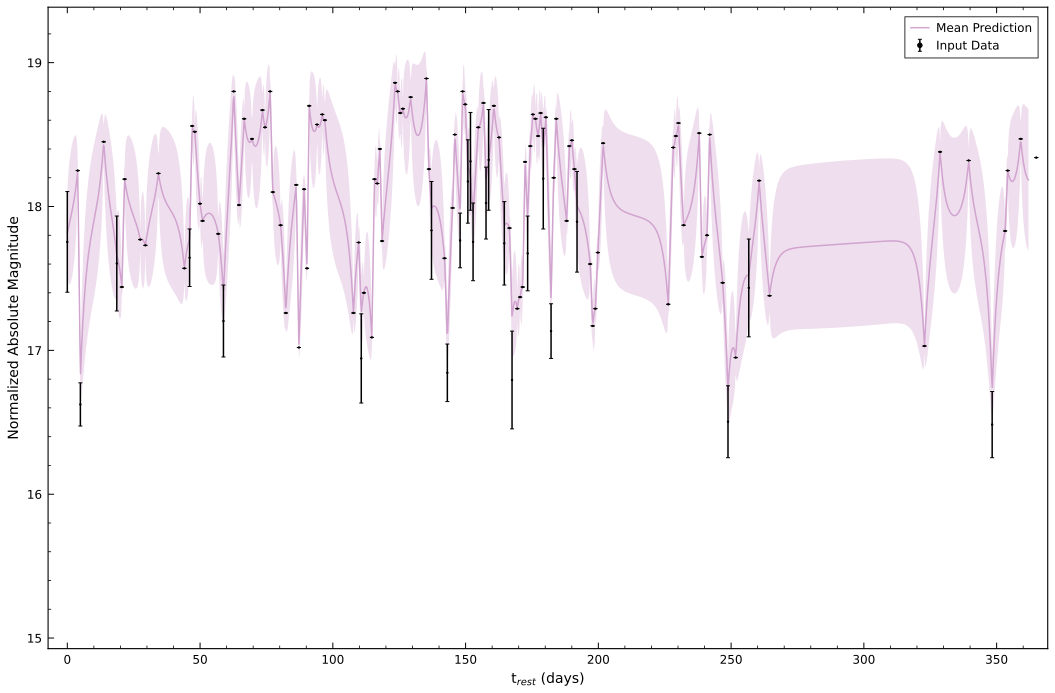

In [12]:
from rqa_utils import scale_lc, plot_predicted_lc

# safe_data = binned_data[binned_data['error'] > 0]
# y, yerr = scale_lc(safe_data['mag'].values, safe_data['error'].values)
# t = safe_data.index - safe_data.index.min()
y, yerr = v['mag'].values, v['error'].values
t = v['time'].values - v['time'].min()

# try to fit light curve with eztao 
plt.style.use('../standard.mplstyle')
from eztao.ts import dho_fit, carma_fit
from eztao.viz import plot_pred_lc
from eztao.carma import DHO_term

# fit
p, q = 2, 1

# best_fit = carma_fit(t, y, yerr, p, q, n_opt=10)
best_fit = dho_fit(t, y, yerr, n_opt=10)
best_fit_kernel = DHO_term(*np.log(best_fit)) # CARMA space

# Example scaling parameters from the original scaling
# original_params = {
#     'mean': binned_df['lumin'].mean(), 
#     'std': binned_df['lumin'].std(), 
#     'max_lumin': binned_df['lumin'].max()
# }

t_pred = np.linspace(0, len(t), len(binned_data))
fig, mu, var = plot_predicted_lc(t, y, yerr, best_fit, 2, t_pred, ylabel=r'Normalized Absolute Magnitude') #, original_params=original_params) #, twinx=binned_df.index.values, twinxlabel='MJD (days)')
# fig.savefig('../plots/1ES_pred_DHO_lc_full.pdf', bbox_inches='tight')

# plot predicted lightcurve at original time points
# from rqa_utils import plot_predicted_lc
# t_orig = df['mjd'].values - df['mjd'].min()
# y_orig, yerr_orig = scale_lc(df['lumin'].values, df['lumin_err'].values, method='z_score')
    # get pred lc

# fig, t_pred, mu, var = plot_predicted_lc(t_orig, y_orig, yerr_orig, best_fit, 2, t_orig, ylabel=r'Normalized L$_{0.3-10\ \mathrm{keV}}$') #, original_params=original_params) #, twinx=binned_df.index.values, twinxlabel='MJD (days)')
# fig.savefig('../plots/1ES_pred_DHO_lc_orig.pdf', bbox_inches='tight')

<Figure size 700x700 with 0 Axes>

/opt/homebrew/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


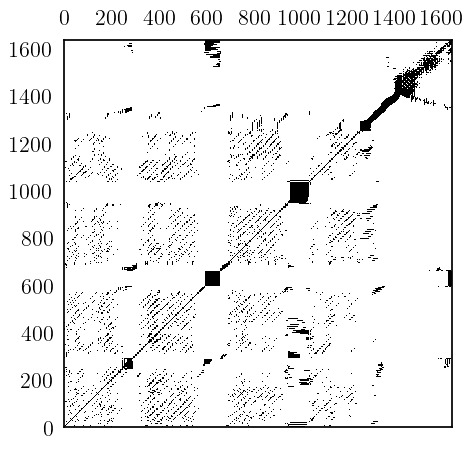

In [8]:
from pyrqa.time_series import TimeSeries, EmbeddedSeries
from pyrqa.settings import Settings
from pyrqa.neighbourhood import FixedRadius
from pyrqa.computation import RQAComputation
from pyrqa.metric import EuclideanMetric, MaximumMetric 
from pyrqa.analysis_type import Classic

from pyunicorn.timeseries import RecurrencePlot

rp = RecurrencePlot(interpolated_lumin, metric='supremum', local_recurrence_rate=0.05, silence_level=2, tau=9, dim=5)
plt.figure(figsize=(7,7))
plt.matshow(rp.recurrence_matrix(), cmap='Greys', origin='lower', interpolation='none')
plt.tick_params(which='both', axis='both', left=False, right=False, top=False, bottom=False)
plt.show()

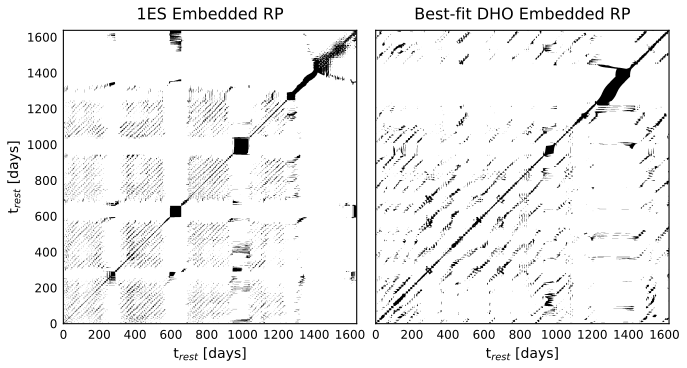

In [16]:
rp = RecurrencePlot(interpolated_lumin, metric='supremum', silence_level=2, local_recurrence_rate=0.05, tau=9, dim=5)
pred_rp = RecurrencePlot(mu, metric='supremum', silence_level=2, local_recurrence_rate=0.05, tau=12, dim=5)

fig, (ax, ax2) = plt.subplots(figsize=(10,5), ncols=2, layout='compressed')
ax.matshow(rp.recurrence_matrix(), origin='lower', interpolation='none', cmap='Greys')
ax2.matshow(pred_rp.recurrence_matrix(), origin='lower', interpolation='none', cmap='Greys')
for axis in (ax, ax2):
    axis.set_xlabel(r't$_{rest}$ [days]')
ax.tick_params(which="both", axis="both", labeltop=False, labelbottom=True, top=False, left=False, bottom=False)
ax2.tick_params(which="both", axis="both", labeltop=False, labelbottom=True, top=False, left=False, bottom=False, labelleft=False)
ax.set_ylabel(r't$_{rest}$ [days]')
# ax.set_title('1ES Unembedded RP')
# ax2.set_title('Best-fit DHO Unembedded RP')
ax.set_title('1ES Embedded RP')
ax2.set_title('Best-fit DHO Embedded RP')
# plt.savefig('../plots/1ES_unembedded_RP_compared_DHO.pdf', bbox_inches='tight')
plt.show()

In [17]:
print("RR DET LAM TT LMAX VMAX LMEAN LENTR VENTR CENTR")
print(rp.recurrence_rate(), rp.determinism(), rp.laminarity(), rp.trapping_time(), rp.max_diaglength(), rp.max_vertlength(), rp.average_diaglength(), rp.average_vertlength(), rp.diag_entropy(), rp.vert_entropy(), rp.complexity_entropy())

# Perform DFA
import nolds
y = interpolated_lumin
alpha = nolds.dfa(y)
print(f"Scaling exponent (alpha) from DFA: {alpha}")

ta = time_reversal_asymmetry_statistic(y, delay=12)
print(f"Time reversal asymmetry:", ta)

RR DET LAM TT LMAX VMAX LMEAN LENTR VENTR CENTR
0.049396506356213316 0.8099666851748404 0.9001682599804651 5.627983772051312 250 81 4.453443012209781 5.627983772051312 1.7705683494707385 2.1275776683742422 0.13133900256645362
Scaling exponent (alpha) from DFA: 1.272623561380581
Time reversal asymmetry: -0.09422494039438786


First MI minimum: 9
First MI minimum: 12


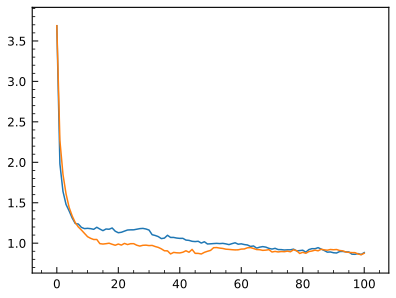

In [13]:
import numpy as np
from sklearn.metrics import mutual_info_score
from embedding import find_first_local_minimum

def mutual_information(time_series, max_delay):
    # Discretize the time series based on quantiles
    def discretize(series, bins):
        quantiles = np.linspace(0, 1, bins + 1)
        bin_edges = np.quantile(series, quantiles)
        digitized = np.digitize(series, bin_edges[1:-1])
        return digitized

    bins = int(np.sqrt(len(time_series)))  # Rule-of-thumb for number of bins
    discretized_series = discretize(time_series, bins)

    mi_values = []
    for tau in range(max_delay + 1):
        # Calculate mutual information between the time series and its delayed version
        if tau == 0:
            mi = mutual_info_score(discretized_series, discretized_series)
        else:
            mi = mutual_info_score(discretized_series[:-tau], discretized_series[tau:])
        mi_values.append(mi)

    return mi_values

# Example usage
dat = interpolated_lumin
max_delay = 100  # Maximum time delay to compute mutual information for
mi = mutual_information(dat, max_delay)
plt.plot(mi)
first_min = find_first_local_minimum(mi)
print(f'First MI minimum: {first_min}')

mi = mutual_information(mu, max_delay)
plt.plot(mi)
first_min = find_first_local_minimum(mi)
print(f'First MI minimum: {first_min}')


Dimension: 2, FNN ratio: 0.9259259259259259
Dimension: 3, FNN ratio: 0.4762762762762763
Dimension: 4, FNN ratio: 0.11896135265700483
Dimension: 5, FNN ratio: 0.03460837887067395
Dimension: 6, FNN ratio: 0.02197802197802198
Dimension: 7, FNN ratio: 0.019030079803560467
Dimension: 8, FNN ratio: 0.019135802469135803
Dimension: 9, FNN ratio: 0.01675977653631285
Dimension: 10, FNN ratio: 0.015605493133583021
Dimension: 11, FNN ratio: 0.013810420590081607

 PRED DHO:
Dimension: 2, FNN ratio: 0.9289127837514934
Dimension: 3, FNN ratio: 0.4444444444444444
Dimension: 4, FNN ratio: 0.10990338164251208
Dimension: 5, FNN ratio: 0.007893139040680024
Dimension: 6, FNN ratio: 0.0030525030525030525
Dimension: 7, FNN ratio: 0.0
Dimension: 8, FNN ratio: 0.0
Dimension: 9, FNN ratio: 0.0
Dimension: 10, FNN ratio: 0.0
Dimension: 11, FNN ratio: 0.0


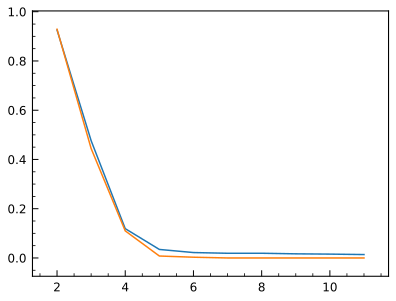

In [15]:
from embedding import false_nearest_neighbors

fnn_ratio = false_nearest_neighbors(interpolated_lumin, max_dim=10, delay=9, rt=10.0)
num_fnn = []
for dim, ratio in enumerate(fnn_ratio, start=2):
    print(f"Dimension: {dim}, FNN ratio: {ratio}")
    num_fnn.append(ratio)
    
plt.figure()
plt.plot(np.arange(2, 12), num_fnn)

# predicted DHO
print("\n PRED DHO:")
fnn_ratio = false_nearest_neighbors(mu, max_dim=10, delay=9, rt=10.0)
num_fnn = []
for dim, ratio in enumerate(fnn_ratio, start=2):
    print(f"Dimension: {dim}, FNN ratio: {ratio}")
    num_fnn.append(ratio)

plt.plot(np.arange(2, 12), num_fnn)  


In [11]:
from networks import *

G = get_recurrence_network(rp.recurrence_matrix())
nodes = get_nodes(G, seed=42, aspect='equal')


In [21]:
import seaborn as sns
cmap = sns.color_palette("rocket", as_cmap=True)
degrees = nodes['degrees']
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(degrees), vmax=max(degrees)))
sm.set_array([])
max_degree = max(degrees)

# # find optimal # clusters
# from clustering import *
# k1 = silhouette_method(rp.recurrence_matrix())
# k2 = elbow_method(rp.recurrence_matrix())
                  
# Apply KMeans clustering
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4) 
clusters = kmeans.fit_predict(rp.recurrence_matrix())

/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


/var/folders/1t/cw_9qncx42l90j4kknls85g80000gn/T/ipykernel_6797/3572133586.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_mapping = plt.cm.get_cmap('cool', len(unique_clusters))


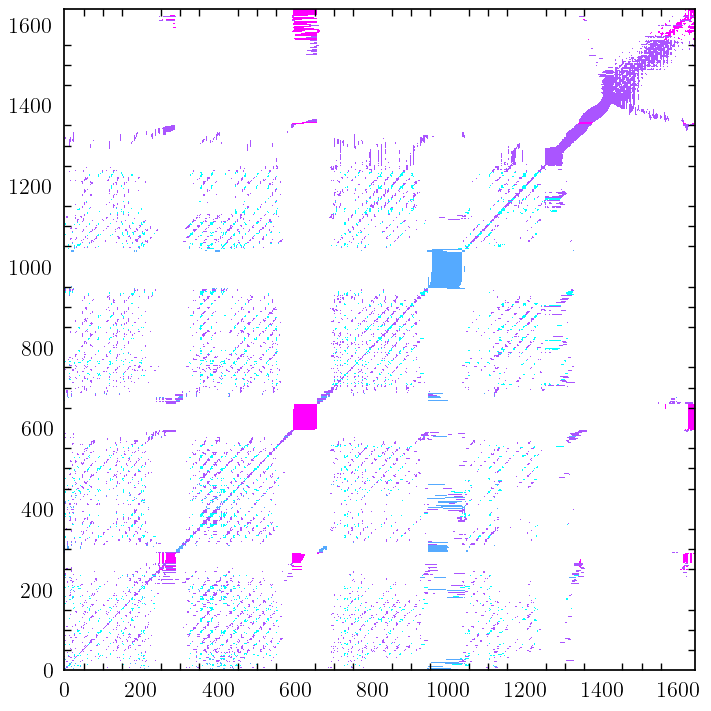

In [22]:
# Get the unique cluster labels and create a mapping to colors
unique_clusters = np.unique(clusters)
color_mapping = plt.cm.get_cmap('cool', len(unique_clusters))

# Create an array to store RGB colors for each cluster label
cluster_colors_rgb = color_mapping(unique_clusters)

# Map the cluster labels to their corresponding colors
cluster_label_to_color = dict(zip(unique_clusters, cluster_colors_rgb))

recurrence_matrix = rp.recurrence_matrix()

# Create a color matrix corresponding to the recurrence_matrix
color_matrix = np.zeros((*recurrence_matrix.shape, 4))  # Initialize a color matrix with 4 channels (RGBA)

for i in range(recurrence_matrix.shape[0]):
    for j in range(recurrence_matrix.shape[1]):
        if recurrence_matrix[i, j] == 1:
            # Assign the color based on the cluster label
            color_matrix[i, j] = cluster_label_to_color[clusters[i]]

# Now plot the recurrence matrix colored by cluster
fig, ax = plt.subplots(figsize=(7,7))
ax.imshow(color_matrix, aspect='auto', interpolation='none', origin='lower', cmap=cmap)
ax.tick_params(labelbottom=True, labelleft=True, bottom=False, right=False, top=False, left=False)
plt.show()

/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/var/folders/1t/cw_9qncx42l90j4kknls85g80000gn/T/ipykernel_6797/1441951552.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_mapping = plt.cm.get_cmap('cool', len(unique_clusters))


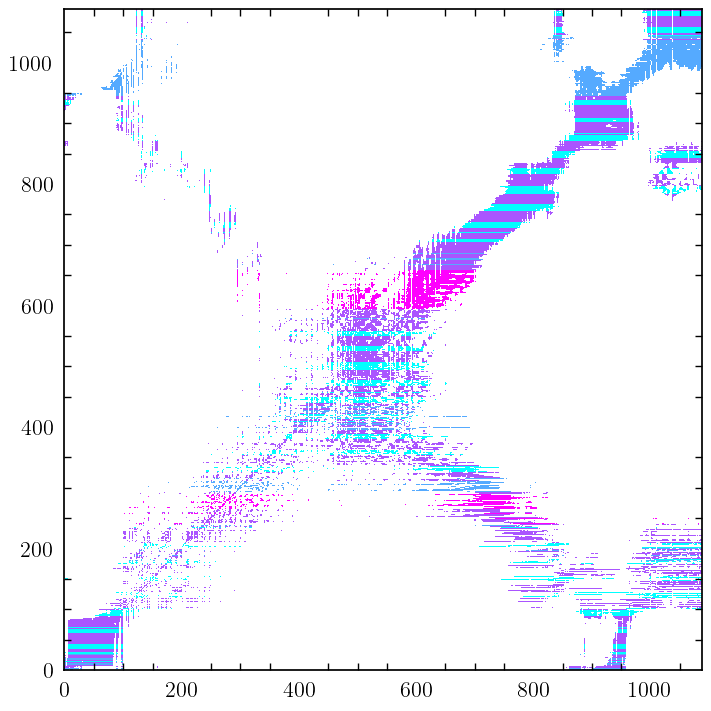

In [27]:
# plot RP for X-ray lc color coded by KMeans clustering of recurrence network nodes

lc_x = pd.read_csv('1ES_binned_lc.csv')
rp_x = RecurrencePlot(lc_x['scaled lumin'].values, metric='supremum', silence_level=2, local_recurrence_rate=0.1, tau=9, dim=5)

# pred_df = pd.read_csv('1ES_pred_DHO_lc.csv')

# Apply KMeans clustering
from sklearn.cluster import KMeans
kmeans_x = KMeans(n_clusters=3) 
clusters_x = kmeans.fit_predict(rp_x.recurrence_matrix())

# Get the unique cluster labels and create a mapping to colors
unique_clusters = np.unique(clusters)
color_mapping = plt.cm.get_cmap('cool', len(unique_clusters))

# Create an array to store RGB colors for each cluster label
cluster_colors_rgb = color_mapping(unique_clusters)

# Map the cluster labels to their corresponding colors
cluster_label_to_color = dict(zip(unique_clusters, cluster_colors_rgb))

recurrence_matrix = rp_x.recurrence_matrix()

# Create a color matrix corresponding to the recurrence_matrix
color_matrix = np.zeros((*recurrence_matrix.shape, 4))  # Initialize a color matrix with 4 channels (RGBA)

for i in range(recurrence_matrix.shape[0]):
    for j in range(recurrence_matrix.shape[1]):
        if recurrence_matrix[i, j] == 1:
            # Assign the color based on the cluster label
            color_matrix[i, j] = cluster_label_to_color[clusters[i]]

# Now plot the recurrence matrix colored by cluster
fig, ax = plt.subplots(figsize=(7,7))
ax.imshow(color_matrix, aspect='auto', interpolation='none', origin='lower', cmap=cmap)
ax.tick_params(labelbottom=True, labelleft=True, bottom=False, right=False, top=False, left=False)
plt.show()

/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/var/folders/1t/cw_9qncx42l90j4kknls85g80000gn/T/ipykernel_6797/3785206995.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_mapping = plt.cm.get_cmap('cool', len(unique_clusters))


TypeError: float() argument must be a string or a real number, not 'dict'

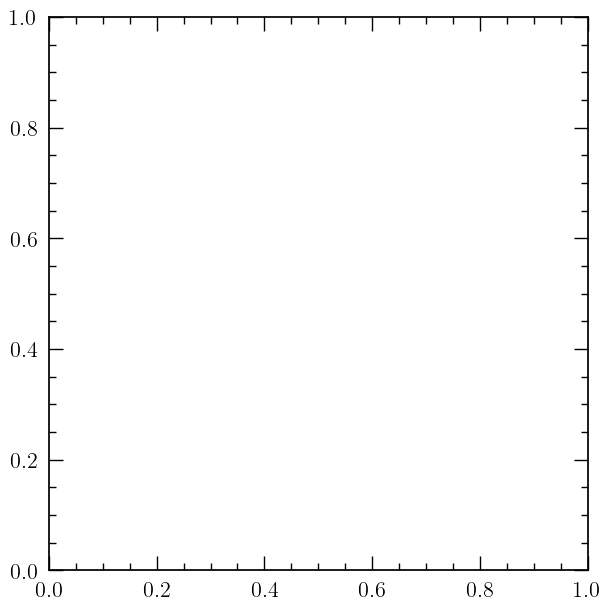

In [29]:
G_x = get_recurrence_network(rp_x.recurrence_matrix())
nodes_x = get_nodes(G_x)

# Apply KMeans clustering
from sklearn.cluster import KMeans
kmeans_x = KMeans(n_clusters=3)  
clusters_x = kmeans.fit_predict(rp_x.recurrence_matrix())

# Get the unique cluster labels and create a mapping to colors
unique_clusters = np.unique(clusters)
color_mapping = plt.cm.get_cmap('cool', len(unique_clusters))

# Create an array to store RGB colors for each cluster label
cluster_colors_rgb = color_mapping(unique_clusters)

# Map the cluster labels to their corresponding colors
cluster_label_to_color = dict(zip(unique_clusters, cluster_colors_rgb))

# Drawing the nodes and the edges with the threshold and transparency
plt.figure(figsize=(6,6))
nx.draw_networkx_nodes(G_x, nodes_x['position']['kamada_kawai'], alpha=0.9, node_color=cluster_label_to_color, node_size = nodes_x['sizes'], cmap=cmap)
nx.draw_networkx_edges(G_x, nodes_x['position']['kamada_kawai'], edge_color='midnightblue', alpha=0.1) #edgelist=edges_to_draw, 
# cbar = plt.colorbar(sm)
# plt.gca().set_axis_off()
# cbar.ax.tick_params(which="both", right=False)
# plt.savefig('../plots/1ES_RN_kamada.pdf', bbox_inches='tight')
plt.show()

In [31]:

# Create a distance matrix
distance_matrix = rp_x._distance_matrix

# Invert the distances to create weights (with handling division by zero)
np.fill_diagonal(distance_matrix, np.inf)  # avoid division by zero for self-distances
weights = 1 / distance_matrix
np.fill_diagonal(weights, 0)  # reset self-connections to 0

# Create a directed graph (use Graph for undirected)
G_weighted = nx.DiGraph()

# Add nodes
G_weighted.add_nodes_from(range(len(distance_matrix)))

# Add weighted edges, assuming symmetry for the distance-based weights
# Use `np.triu_indices` to get indices for the upper triangle
rows, cols = np.triu_indices_from(weights, k=1)
edges = zip(rows, cols, weights[rows, cols])

# Add edges to the graph
G_weighted.add_weighted_edges_from(edges)

KeyboardInterrupt: 

/opt/homebrew/anaconda3/lib/python3.11/site-packages/IPython/core/events.py:93: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  func(*args, **kwargs)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


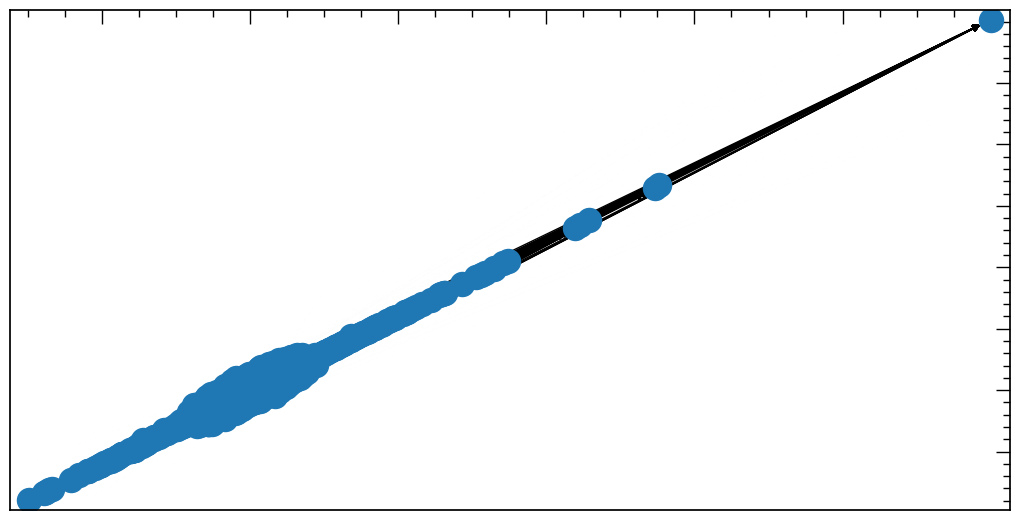

In [32]:
nx.draw(G_weighted)

In [33]:
import networkx as nx

# G is a NetworkX graph
G = G_weighted

# Eigenvector Centrality
eigenvector_centrality = nx.eigenvector_centrality(G)

# Closeness Centrality
closeness_centrality = nx.closeness_centrality(G)

# Edge Betweenness Centrality
edge_betweenness_centrality = nx.edge_betweenness_centrality(G)

# Assortativity Coefficient (for degree assortativity)
assortativity_coefficient = nx.degree_assortativity_coefficient(G)

# Harmonic Centrality
harmonic_centrality = nx.harmonic_centrality(G)

# Communicability
communicability = nx.communicability(G)

# Community Detection using the Clauset-Newman-Moore greedy modularity maximization
# from networkx.algorithms.community import greedy_modularity_communities
# communities = greedy_modularity_communities(G)

# K-core Decomposition
k_core = nx.k_core(G)

# Printing the measures for demonstration
print("Eigenvector Centrality:", eigenvector_centrality)
print("Closeness Centrality:", closeness_centrality)
print("Edge Betweenness Centrality:", edge_betweenness_centrality)
print("Assortavitiy Coefficient:", assortativity_coefficient)
print("Harmonic Centrality:", harmonic_centrality)
print("Communicability:", communicability)
print("K-Core Decomposition:", k_core)


PowerIterationFailedConvergence: (PowerIterationFailedConvergence(...), 'power iteration failed to converge within 100 iterations')

In [34]:

def calculate_recurrence_matrix_trend(R):
    """
    Calculate the trend of a recurrence matrix.
    
    Parameters:
    - R: A square numpy array representing the recurrence matrix.
    
    Returns:
    - trend: The slope of the trendline fitted to the recurrence points density.
    """
    
    # Check if the input matrix is square
    if R.shape[0] != R.shape[1]:
        raise ValueError("The recurrence matrix must be square.")
    
    # Initialize a list to hold the density of recurrence points for each diagonal
    diagonal_density = []

    # Iterate over the diagonals
    for offset in range(-R.shape[0] + 1, R.shape[0]):
        diagonal_density.append(np.mean(np.diagonal(R, offset=offset)))

    # Fit a first degree polynomial (line) to the densities
    # and return the slope, which represents the trend
    trend = np.polyfit(range(-R.shape[0] + 1, R.shape[0]), diagonal_density, 1)[0]

    return trend

# Example usage:
trend = calculate_recurrence_matrix_trend(rp.recurrence_matrix())
print(f"The trend of the recurrence matrix is: {trend}")


The trend of the recurrence matrix is: -9.122407196797332e-08


In [47]:
import numpy as np
from pyrqa.settings import Settings
from pyrqa.computation import RQAComputation
from pyrqa.neighbourhood import FixedRadius
from pyrqa.metric import EuclideanMetric, MaximumMetric 

def get_close_returns(time_series, epsilon, theiler=1, metric=MaximumMetric, plot=True):
    """
    Calculate the close returns of a recurrence plot using pyrqa.

    Parameters:
    - time_series_data: A numpy array representing the time series data.
    - radius: A fixed radius for neighbourhood.

    Returns:
    - line_length_hist: Histogram of line lengths from the recurrence plot.
    """

    # Define the settings for the recurrence plot
    settings = Settings(time_series,
                        neighbourhood=FixedRadius(epsilon),
                        similarity_measure=metric,
                        theiler_corrector=theiler)
    
    # Perform RQA computation
    rqa = RQAComputation.create(settings,verbose=False).run()
    
    # Access the histogram of line lengths
    line_length_hist = rqa.diagonal_frequency_distribution
    
    if plot:
        plt.plot(line_length_hist)
        plt.title(r'Close Returns $P(l)$')
        plt.show()
        
    return line_length_hist



In [ ]:
from rqa_utils import convert_epsilon
ts = lc_x['scaled lumin'].values
time_series = TimeSeries(ts, time_delay=12, embedding_dimension=5)
# epsilon = convert_epsilon(time_series, 0.05, theiler=12*5)
print("epsilon=", epsilon)
line_length_hist = get_close_returns(time_series, 0.40234375)

In [ ]:
tau, dim = 12, 5
from rqa_utils import find_epsilon

# epsilon = find_epsilon(ts, 0.05, tau=tau, dim=dim)
    
time_series = TimeSeries(ts, embedding_dimension=dim, time_delay=tau)
settings = Settings(time_series,
                    analysis_type=Classic,
                 neighbourhood=FixedRadius(0.40234375),
                    similarity_measure=MaximumMetric,
                    theiler_corrector=tau*dim)
                    
computation = RQAComputation.create(settings)
result = computation.run()